In [31]:
# Run on GPU server
# import os
# os.chdir('/root/autodl-tmp/FinanceTech/')

In [32]:
import pickle
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, Dataset
from codes.nn_utils import *
from codes.loss import ic_loss
from codes.backtest import show_back_test
from tqdm import tqdm
import matplotlib.pyplot as plt

In [33]:
with open("factors/factor_df_list.pkl", "rb") as f:
    X = pickle.load(f)
with open("factors/y.pkl", "rb") as f:
    y = pickle.load(f)
print(len(X), " ", X[0].shape)
print(y.shape)

100   (1369, 503)
(1369, 503)


In [34]:
# 数据清洗
X, y = fill_na(X, y)

In [35]:
# 将X和y转为Tensor
X = convert_to_tensor(X)
y = torch.Tensor(y.values)
print(type(X), " : ", X.shape)
print(type(y), " : ", y.shape)

<class 'torch.Tensor'>  :  torch.Size([1369, 503, 100])
<class 'torch.Tensor'>  :  torch.Size([1369, 503])


In [36]:
X = X.double()
y = y.double()
print(X.isnan().any())
print(X.isinf().any())
print(y.isnan().any())
print(y.isinf().any())

tensor(False)
tensor(False)
tensor(False)
tensor(False)


In [37]:
def std_(X):
    mean = torch.mean(X, dim=0, keepdim=True)
    std = torch.std(X, dim=0, keepdim=True)

    X = (X - mean) / (std + 1e-6)
    return X
X = std_(X)

In [38]:
# 分割数据
# 根据train, test, val的比例分割数据集
train_prop = 0.6
test_prop = 0.2
val_prop = 0.2
train_X, train_y, test_X, test_y , val_X , val_y = split_train_test_val(X, y, train_prop, test_prop, val_prop)
print(f"train_X : {type(train_X)}, {train_X.shape}")
print(f"train_y : {type(train_y)}, {train_y.shape}")
print(f"test_X : {type(test_X)}, {test_X.shape}")
print(f"test_y : {type(test_y)}, {test_y.shape}")
print(f"val_X : {type(val_X)}, {val_X.shape}")
print(f"val_y : {type(val_y)}, {val_y.shape}")

train_X : <class 'torch.Tensor'>, torch.Size([1369, 503, 100])
train_y : <class 'torch.Tensor'>, torch.Size([1369, 503])
test_X : <class 'torch.Tensor'>, torch.Size([274, 503, 100])
test_y : <class 'torch.Tensor'>, torch.Size([274, 503])
val_X : <class 'torch.Tensor'>, torch.Size([274, 503, 100])
val_y : <class 'torch.Tensor'>, torch.Size([274, 503])


#

In [39]:
class AutoEncoderDataset(Dataset):
    def __init__(self, X):
        super(AutoEncoderDataset, self).__init__()
        self.X = X

    def __getitem__(self, index):
        X = torch.Tensor(self.X[index])
        return X, X

    def __len__(self):
        return len(self.X)

In [40]:
class Encoder(nn.Module):
    def __init__(self, in_features):
        super(Encoder, self).__init__()
        self.input_layer = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=128),
        )

        self.hidden_layer1 = nn.Sequential(
            nn.Linear(in_features=128, out_features=100),
        )

        self.hidden_layer2 = nn.Sequential(
            nn.Linear(in_features=100, out_features=96),
        )

        self.hidden_layer3 = nn.Sequential(
            nn.Linear(in_features=96, out_features=64),
        )

        self.res_connect = nn.Linear(in_features=in_features, out_features=64)

    def forward(self, X):
        temp = self.res_connect(X)
        X = torch.tanh(self.input_layer(X))
        X = torch.tanh(self.hidden_layer1(X))
        X = torch.tanh(self.hidden_layer2(X))
        X = torch.tanh(self.hidden_layer3(X))
        return X + temp

class Decoder(nn.Module):
    def __init__(self, out_features):
        super(Decoder, self).__init__()
        self.hidden_layer3 = nn.Sequential(
            nn.Linear(in_features=64, out_features=96),
        )

        self.hidden_layer2 = nn.Sequential(
            nn.Linear(in_features=96, out_features=100),
        )

        self.hidden_layer1 = nn.Sequential(
            nn.Linear(in_features=100, out_features=128),
        )

        self.output_layer = nn.Sequential(
            nn.Linear(in_features=128, out_features=out_features),
        )

        self.res_connect = nn.Linear(in_features=64, out_features=out_features)

    def forward(self, X):
        temp = self.res_connect(X)
        X = torch.tanh(self.hidden_layer3(X))
        X = torch.tanh(self.hidden_layer2(X))
        X = torch.tanh(self.hidden_layer1(X))
        X = torch.tanh(self.output_layer(X))
        return X + temp

class AutoEncoder(nn.Module):
    def __init__(self, in_features):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder(in_features=in_features)
        self.decoder = Decoder(out_features=in_features)

    def forward(self, X):
        X = self.encoder(X)
        X = self.decoder(X)
        return X

In [41]:
# 设置随机数种子
setup_seed(1)

In [42]:
show_cuda_info()

Cuda is available :  True
Cuda num :  1
Current cuda index :  0
Current cuda name :  NVIDIA GeForce RTX 4090


# 准备数据集

In [43]:
train_dataset = AutoEncoderDataset(X=train_X)
test_dataset = AutoEncoderDataset(X=test_X)
val_dataset = AutoEncoderDataset(X=val_X)

# 准备训练参数

In [44]:
ae_train_loss_list = []
ae_val_loss_list = []
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

auto_encoder = AutoEncoder(in_features=X.shape[-1])
auto_encoder.to(device)
auto_encoder = auto_encoder.double()
auto_encoder.apply(init_weights)

ae_epoch_size = 250
ae_lr = 0.00005
ae_batch_size = 64
ae_loss_func = nn.MSELoss()
ae_optimizer = torch.optim.Adam(auto_encoder.parameters(), lr=ae_lr, weight_decay=0.01)

In [45]:
# 包装成DataLoader
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=ae_batch_size)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=ae_batch_size)
val_dataloader = DataLoader(val_dataset, shuffle=True, batch_size=ae_batch_size)

100%|██████████| 250/250 [02:51<00:00,  1.46it/s]


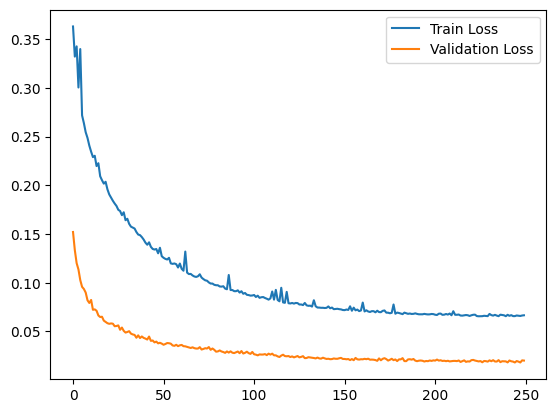

In [46]:
for epoch in tqdm(range(ae_epoch_size)):
    # 训练
    auto_encoder.train()
    epoch_train_loss = []  # 每个epoch开始时重置训练损失列表
    for X, y in train_dataloader:
        ae_optimizer.zero_grad()
        # X = X.squeeze()
        # y = y.squeeze()
        y_pred = auto_encoder(X.to(device))
        train_loss = ae_loss_func(input=y_pred.squeeze(), target=y.to(device))
        epoch_train_loss.append(train_loss.detach().cpu().item())
        train_loss.backward()
        # clip_grad_norm(auto_encoder, 1.)
        ae_optimizer.step()
    ae_train_loss_list.append(np.mean(epoch_train_loss))  # 计算并记录每个epoch的平均训练损失

    # 测试
    auto_encoder.eval()
    epoch_val_loss = []  # 每个epoch开始时重置验证损失列表
    with torch.no_grad():
        for X_val, y_val in val_dataloader:
            y_val_pred = auto_encoder(X_val.to(device).squeeze())
            val_loss = ae_loss_func(input=y_val_pred.squeeze(), target=y_val.to(device).squeeze())
            epoch_val_loss.append(val_loss.detach().cpu().item())
    ae_val_loss_list.append(np.mean(epoch_val_loss))  # 计算并记录每个epoch的平均验证损失
plt.plot(ae_train_loss_list, label='Train Loss')
plt.plot(ae_val_loss_list, label='Validation Loss') # 画出验证集的损失曲线
plt.legend() # 新增，显示图例
plt.show()

In [47]:
torch.save(auto_encoder, "models/autoencoder.pth")

In [48]:
# auto_encoder = torch.load("models/autoencoder.pth")

In [49]:
class GRUDataset(Dataset):
    def __init__(self, X: torch.Tensor, y: torch.Tensor, days: int):
        super(GRUDataset, self).__init__()
        self.X = X
        self.y = y
        self.days = days
        assert len(self.X) == len(self.y)

    def __getitem__(self, index):
        if index > len(self.X) - self.days:
            raise ValueError("Index should be greater or equal to 'days'")

        X = torch.Tensor(self.X[index:index+self.days])
        y = torch.Tensor(self.y[index+self.days])
        return X, y

    def __len__(self):
        # 减去 'days'，因为前 'days' 天的数据不能作为一个完整的输入
        return len(self.X) - self.days
class GRU(nn.Module):
    def __init__(self, encoder: nn.Module,
                 hidden_size: int,
                 output_size: int,
                 num_layers: int,
                 dropout: float):
        super(GRU, self).__init__()
        self.encoder = encoder
        self.gru = nn.GRU(input_size=64, hidden_size=hidden_size, batch_first=False, dropout=dropout, num_layers=num_layers)
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, X):
        with torch.no_grad():
            X = self.encoder(X)
        X, _ = self.gru(X)
        X = self.output_layer(X[-1])  # 获取最后一天的隐藏状态
        return X

In [50]:
days = 20
train_dataset = GRUDataset(X=train_X, y=train_y, days=days)
test_dataset = GRUDataset(X=test_X, y=test_y, days=days)
val_dataset = GRUDataset(X=val_X, y=val_y, days=days)

In [51]:
gru_train_loss_list = []
gru_val_loss_list = []
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

gru = GRU(encoder=auto_encoder.encoder, hidden_size=128, output_size=1, dropout=0.2, num_layers=3)
gru.to(device)
gru = gru.double()
gru.apply(init_weights)

gru_epoch_size = 30
gru_lr = 0.0001
gru_batch_size = 1

# gru_loss_func = weight_ic_loss
gru_loss_func = ic_loss
# gru_loss_func = nn.MSELoss()

gru_optimizer = torch.optim.Adam(gru.parameters(), lr=gru_lr)
# 包装成DataLoader
train_dataloader = DataLoader(train_dataset, shuffle=False, batch_size=gru_batch_size)  # 是否可以shuffle？
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=gru_batch_size)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=gru_batch_size)

100%|██████████| 30/30 [19:37<00:00, 39.24s/it]


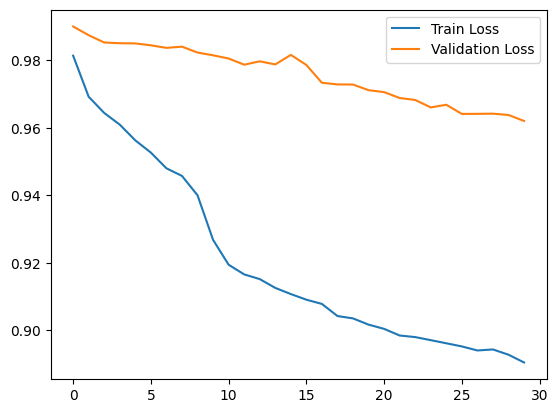

In [52]:
for epoch in tqdm(range(gru_epoch_size)):
    # 训练
    gru.train()
    epoch_train_loss = []  # 每个epoch开始时重置训练损失列表
    for X, y in train_dataloader:
        gru_optimizer.zero_grad()
        X = X.squeeze()
        y = y.squeeze()
        y_pred = gru(X.to(device))
        loss = gru_loss_func(y_pred=y_pred.squeeze(), y=y.to(device))
        # loss = gru_loss_func(input=y_pred.squeeze(), target=y.to(device))
        epoch_train_loss.append(loss.detach().cpu().item())
        loss.backward()
        clip_grad_norm(gru, 1.)
        gru_optimizer.step()
    gru_train_loss_list.append(np.mean(epoch_train_loss))  # 计算并记录每个epoch的平均训练损失

    # 测试
    gru.eval()
    epoch_val_loss = []  # 每个epoch开始时重置验证损失列表
    with torch.no_grad():
        for X_val, y_val in val_dataloader:
            y_val_pred = gru(X_val.to(device).squeeze())
            val_loss = gru_loss_func(y_pred=y_val_pred.squeeze(), y=y_val.to(device).squeeze())
            # val_loss = gru_loss_func(input=y_val_pred.squeeze(), target=y_val.to(device).squeeze())
            epoch_val_loss.append(val_loss.detach().cpu().item())
    gru_val_loss_list.append(np.mean(epoch_val_loss))  # 计算并记录每个epoch的平均验证损失
plt.plot(gru_train_loss_list, label='Train Loss')
plt.plot(gru_val_loss_list, label='Validation Loss') # 新增，画出验证集的损失曲线
plt.legend() # 新增，显示图例
plt.show()

In [53]:
# torch.save(gru, "models/ae_gru.pth")

In [54]:
gru = torch.load("models/ae_gru.pth")

In [55]:
def get_predictions(model, dataloader, device):
    model.eval()  # 设置模型为评估模式
    predictions = []

    with torch.no_grad():  # 关闭梯度计算
        for X, _ in tqdm(dataloader):  # 我们只关心输入数据，不需要标签
            X = X.to(device).squeeze()
            y_pred = model(X)
            # print(y_pred.transpose(1, 0).shape)
            # raise
            predictions.append(y_pred.transpose(1, 0).cpu().numpy())  # 转换为numpy数组并添加到列表中

    predictions = np.concatenate(predictions, axis=0)  # 将所有预测结果拼接到一起
    return predictions

In [56]:
# 获取各个数据集上的预测结果
train_predictions = get_predictions(gru, train_dataloader, device)
test_predictions = get_predictions(gru, test_dataloader, device)
val_predictions = get_predictions(gru, val_dataloader, device)
print(f"train_predictions: {train_predictions.shape}")
print(f"test_predictions: {test_predictions.shape}")
print(f"val_predictions: {val_predictions.shape}")

100%|██████████| 254/254 [00:02<00:00, 120.50it/s]

train_predictions: (1349, 503)
test_predictions: (254, 503)
val_predictions: (254, 503)


In [57]:
# 保存预测结果
np.save("data/ae_gre_train_predictions.npy", train_predictions)
np.save("data/ae_gre_test_predictions.npy", test_predictions)
np.save("data/ae_gre_val_predictions.npy", val_predictions)

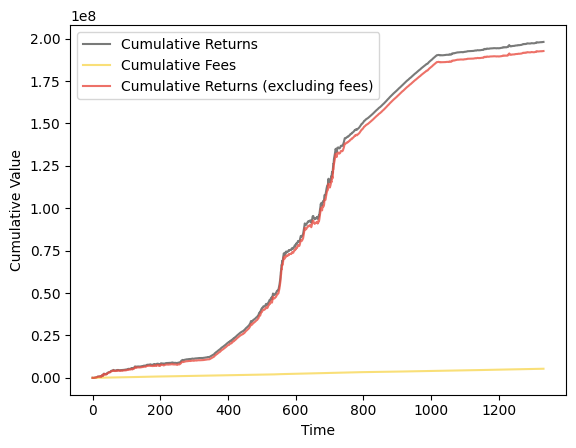

returns    : 1.8215         
ir         : 0.3983         
sharpe     : 6.3231         
turnover   : 0.1008         
draw_down  : 5048494.1676   


In [58]:
show_back_test(train_y.numpy(), train_predictions, decay=16)

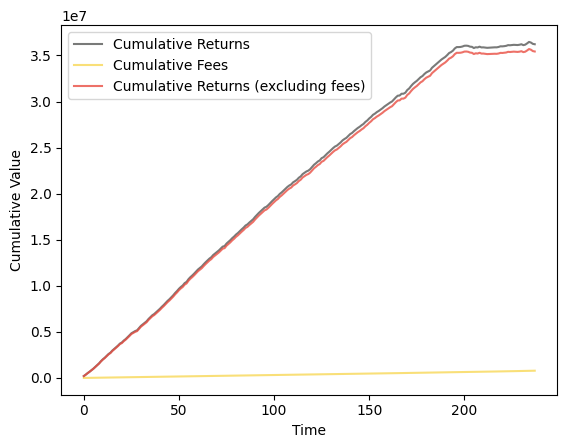

returns    : 1.8759         
ir         : 1.8171         
sharpe     : 28.8460        
turnover   : 0.0826         
draw_down  : 439534.8053    


In [59]:
show_back_test(test_y.numpy(), test_predictions, decay=16)

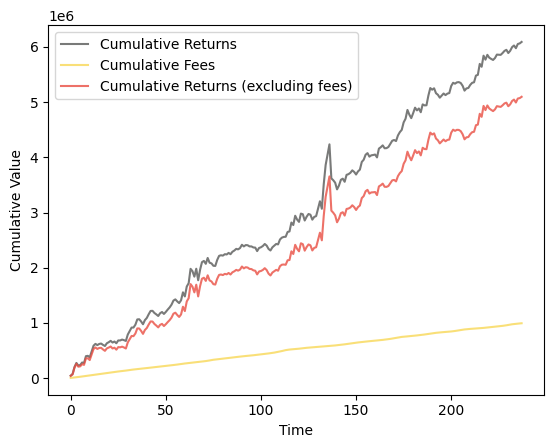

returns    : 0.2698         
ir         : 0.2462         
sharpe     : 3.9085         
turnover   : 0.1044         
draw_down  : 1061758.1492   


In [60]:
show_back_test(val_y.numpy(), val_predictions, decay=16)